In [ ]:
#Read data
data <- read.csv("/content/inventory_log_extended.csv")

#Fix timestamp conversion
data$timestamp <- as.POSIXct(data$timestamp, format = "%d-%m-%Y %H:%M")

#Feature engineering
data$hour <- as.numeric(format(data$timestamp, "%H"))
data$wday <- as.numeric(format(data$timestamp, "%u"))  # Day of the week
data$day <- as.numeric(format(data$timestamp, "%d"))

#Split into train and test
set.seed(123)
split_ratio <- 0.7
n <- nrow(data)
train_indices <- sample(1:n, size = floor(split_ratio * n))

train_data <- data[train_indices, ]
test_data <- data[-train_indices, ]


   stock_left          hour            wday           day        
 Min.   : 0.000   Min.   : 0.00   Min.   :1.00   Min.   : 5.000  
 1st Qu.: 6.000   1st Qu.: 6.00   1st Qu.:2.00   1st Qu.: 7.000  
 Median : 8.000   Median :12.00   Median :4.00   Median : 9.000  
 Mean   : 7.551   Mean   :11.73   Mean   :4.17   Mean   : 9.465  
 3rd Qu.: 9.000   3rd Qu.:18.00   3rd Qu.:6.00   3rd Qu.:12.000  
 Max.   :50.000   Max.   :23.00   Max.   :7.00   Max.   :14.000  

In [ ]:
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
features <- c("stock_left", "hour", "wday", "day")

scale_params <- preProcess(train_data[, features], method = c("center", "scale"))
train_scaled <- predict(scale_params, train_data[, features])
test_scaled <- predict(scale_params, test_data[, features])

In [ ]:
set.seed(42)
k <- 3

kmeans_model <- kmeans(train_scaled, centers = k)

# Predict cluster assignments
train_data$cluster <- kmeans_model$cluster

In [ ]:
library(purrr)
get_anomaly_score <- function(x, centers) {
  min(apply(centers, 1, function(c) sum((x - c)^2)))
}

test_scores <- apply(test_scaled, 1, function(row) get_anomaly_score(row, kmeans_model$centers))
test_data$anomaly_score <- test_scores

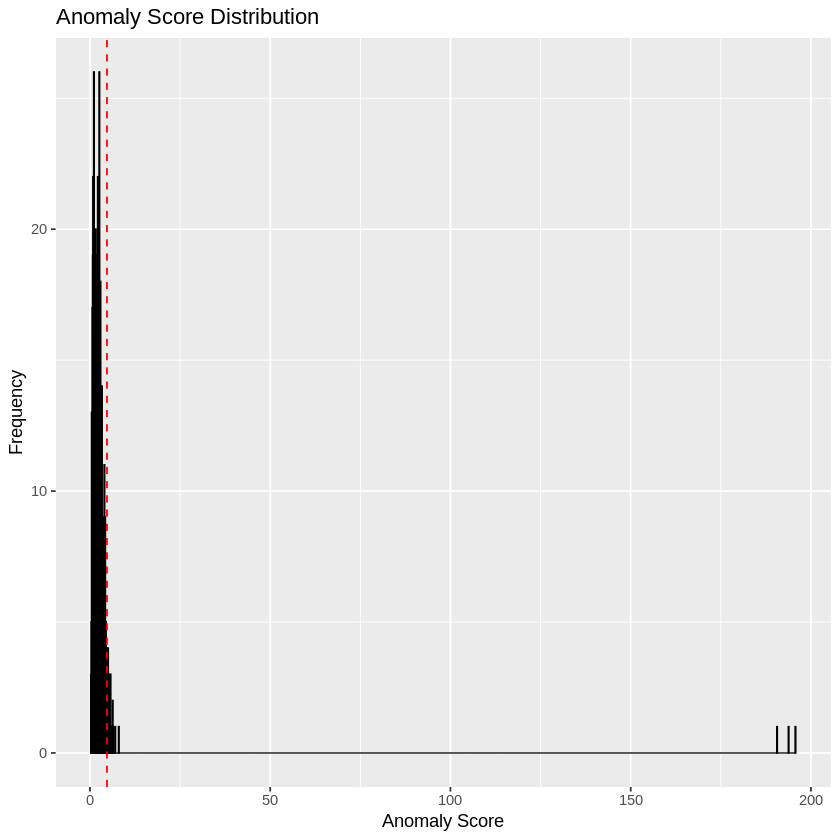

In [ ]:
#Visualize and Evaluate
# Set a threshold for anomaly detection
threshold <- quantile(test_data$anomaly_score, 0.95)  # top 5% most anomalous

# Create binary predictions
test_data$predicted_label <- ifelse(test_data$anomaly_score > threshold, "anomaly", "normal")
library(ggplot2)

ggplot(test_data, aes(x = anomaly_score)) +
  geom_histogram(binwidth = 0.1, fill = "skyblue", color = "black") +
  geom_vline(xintercept = threshold, color = "red", linetype = "dashed") +
  labs(title = "Anomaly Score Distribution", x = "Anomaly Score", y = "Frequency")

# Simulate some ground truth labels for demo
set.seed(42)
test_data$true_label <- sample(c("normal", "anomaly"), size = nrow(test_data), prob = c(0.95, 0.05), replace = TRUE)

In [ ]:
# Load library
library(caret)

conf_matrix <- confusionMatrix(
  factor(test_data$predicted_label, levels = c("normal", "anomaly")),
  factor(test_data$true_label, levels = c("normal", "anomaly"))
)

print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction normal anomaly
   normal     543      27
   anomaly     28       2
                                          
               Accuracy : 0.9083          
                 95% CI : (0.8824, 0.9302)
    No Information Rate : 0.9517          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0196          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.95096         
            Specificity : 0.06897         
         Pos Pred Value : 0.95263         
         Neg Pred Value : 0.06667         
             Prevalence : 0.95167         
         Detection Rate : 0.90500         
   Detection Prevalence : 0.95000         
      Balanced Accuracy : 0.50996         
                                          
       'Positive' Class : normal          
         